In [4]:
import numpy as np
import scipy as sp
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import numpy.linalg as LA

# SINDy and PDEs

Here we discuss using SINDy to find solutions to nonlinear PDEs by first simulating data using a split-step method and finally running the sparse regression on the spatial and temporal derivatives to extract the nonlinear terms. 

## Split-Step Method

We start by simulating our desired PDE using a split-step method. For the purposes of this demonstration we will be using Burger's Equation 
$$
u_t = u_x-uu_x+0.0001u_{xx}
$$
here we include defusion for numerical stability in the simulation.

We collect the data in an $M\times N$ matrix where $M$ is the number of timesteps and $N$ is our spatial resolution.

 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:00<00:00, 84.01it/s]


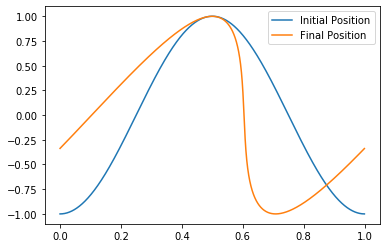

In [5]:
global L, NL, U, Ul, Unl, x, xt, xtft, k
global mu, alpha, beta, dt, NPoint, Lx

### Parameters/Inputs

NPoints = 2**11      # Spatial Resolution
t_stop = .15        # Stoping Time
dt = .0001           # Time step size
sampling_rate = 20   # How often do you save?
Lx = 1               # Space Size

# Input Coefficients [1, u, u_x, u_xx, u^2, u*u_x, u*u_xx, u_x^2, u_x*u_xx, u_xx^2]
c = [0,0,1,.0001,0,-1, 0 ,0,0,0] #Burger's Equation


### Matrices 
dx = Lx/NPoints                             # Space step size 
t = np.arange(0, NPoints)                   # time space      
kx = np.fft.fftfreq(NPoints, 1/NPoints)     # Frequency for fourier transform
kx = 2*np.pi/Lx*kx                          # Adjusting by length of interval
L = c[1] + c[2]*1j*kx - c[3]*kx**2          # Calculate Linear piece exactly        
NL = np.empty(NPoints, dtype = complex)     # Allocate Space for Nonlinear

for j in range(NPoints):                    # Calculate Nonlinear piece
    if abs(L[j])<0.000001:
        NL[j] = dt 
    else:
        NL[j] = (np.exp(L[j]*dt)-1)/L[j]


### Initial Condition

x = t/NPoints*Lx
U = np.cos(2*np.pi*(x-Lx/2)/Lx) # Initial Condition here


# Plot initial condition

fig1 = plt.figure()
ax1 = plt.axes()
ax1.plot(x, U, label = 'Initial Position')
Ul = np.fft.fft(U)


# Calculate Derivatives for first step

U_x = np.fft.ifft(1j*kx*np.fft.fft(U))
U_xx = np.fft.ifft(-kx**2*np.fft.fft(U))


# Find Nonlinear piece

Unl = np.fft.fft(np.dot(c[4:], [U**2, U*U_x, U*U_xx, U_x**2, U_x*U_xx, U_xx**2]))

imax = int(t_stop/(dt*sampling_rate)) 
kmax = sampling_rate

U_save = np.empty([NPoints,imax-1], dtype = complex)
U_save[:,0] = U


### Time Evolution

pbar = tqdm(total = imax-1,position = 0, leave = True)

for i in range(1,imax-1):
    
    for k in range(kmax):
        U = np.multiply(np.exp(L*dt),Ul)+np.multiply(NL, Unl) # Move Forward in Fourier Space
        Ul = np.fft.ifft(U) # Move back to real space
        if k == kmax-1:
            U_save[:,i] = Ul # Save every sampling_rate timesteps
        U_x = np.fft.ifft(1j*kx*U) # Calculate new derivatives
        U_xx = np.fft.ifft(-kx**2*U)
        Unl = np.fft.fft(np.dot(c[4:], [Ul**2, Ul*U_x, Ul*U_xx, U_x**2, U_x*U_xx, U_xx**2])) # Calculate new nonlinear piece
        Ul = U
        if np.isnan(Ul[0]) == True:
            sys.exit()
    pbar.update(1)        
pbar.close()     
       
psi2 = np.fft.ifft(Ul)
ax1.plot(x, np.real(psi2), label = 'Final Position')       
ax1.legend()
plt.show()

We can then animate our final solution.

In [6]:
import matplotlib.animation as animation
%matplotlib qt
j=0
fig = plt.figure()
fig.set_dpi(100)
ax2= plt.axes() 

def animate(j):
    j +=1 
    ax2.clear()
    ax2.plot(x,np.real(U_save[:,j]))
    ax2.plot(0,0, label = j/imax)
    ax2.legend()
    ax2.set_ylim(-2,2)
    ax2.set_xlim(0,Lx)
    
    
anim = animation.FuncAnimation(fig,animate, frames=100, interval = 100, repeat = True)

## Using SINDy

We now feed these time series into SINDy. We first calculate spacial derivatives in Fourier space to attain spectral accuracy, as oppsoed to finite differences. It should be noted that this bears the assumption that our space behaves periodically. If this is not the case, higher-order finite difference methods can be employed to attain similar results. When approximating the time derivative, we use a central difference, with a one-sided 2nd order finite difference method on the boundaries. However, we have updated this to work with higher-order differentiations to create the uploaded plots below. It should be noted that we have found no noticable difference between the two differentiation methods. These create $m\times n $ matricies of $u_t,u_x,$ and $u_{xx}$.

In [7]:
U = np.real(np.transpose(U_save))
pbar_t = tqdm(total = U.shape[0]-1, position = 0, leave = True)
### Estimate Time Derivatives
U_t = np.empty(U.shape, dtype = complex)
for i in range(U.shape[0]-1):
        U_t[i,:] = (U[i+1,:]-U[i-1,:])/(2*dt*sampling_rate)
        pbar_t.update(1)

pbar_t.close()

        
U_t[0,:] = (-3/2*U[0,:]+2*U[1,:]-1/2*U[2,:])/dt/sampling_rate
U_t[-1,:] = (1/2*U[-3,:]-2*U[-2,:]+3/2*U[-1,:])/dt/sampling_rate

U_x = np.fft.ifft(1j*kx*np.fft.fft(U, axis = 1))
U_xx = np.fft.ifft(-kx**2*np.fft.fft(U, axis = 1))


100%|███████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 14612.21it/s]


In order to use SINDy for linear regression, we must first transform our matrices into vectors. We discuss the reasoning for this below. However, for $u, u_t, u_x, u_{xx}$ we transform each $M\times N$ matrix into a $MN\times 1$ vector and proceed by using SINDy as normal. Our library of $u, u_x, u_{xx}$ is used to construct $\Theta$ which consists of the functions $1, u, u_x, u_{xx}, u^2, uu_x, uu_{xx}, u_x^2, u_xu_{xx}, u_{xx}^2$. However it can be easily modified to include other terms such as $|u|$, higher order terms or other nonlinearities. 

In order to allow for ease of access, we construct $\Theta$ in a modular fashion. It is reasonable to simply define $\Theta$ as $$
\Theta = 
\begin{bmatrix}
| & | & \dots & |\\
1 & u & \dots & u_{xx}^2 \\
| & | & \dots & |
\end{bmatrix}
$$
using the "np.column_stack" function in numpy. However, this is not easily modified as each entry must be incorperated individually. Instead, we construct a library with all possible linear terms. We then use imbedded for-loops to create all possible polynomial combinations of these terms. In the code below, we only consider quadratic terms, but when considering the Complex Ginsburg-Landau Equation later, we include cubic terms in our regression. 

Using this modular fashion makes it signifcantly easier to incoperate other possible terms such as higher order derivatives, absolute value terms, and other potential nonlinearities.

In [8]:
U_new = U.flatten(order = 'F')
U_t_new = U_t.flatten(order = 'F')
U_x_new = U_x.flatten(order = 'F')
U_xx_new = U_xx.flatten(order = 'F')

Library = np.column_stack([U_new,U_x_new,U_xx_new])

total_variable = 3
total_guesses = 1+total_variable+6
Theta = np.empty([(U.shape[0])*U.shape[1], total_guesses], dtype = complex)

i = 0
Theta[:,i] = np.ones([(U.shape[0])*U.shape[1]])
i = i+1

for j in range(total_variable):
    Theta[:,i] = Library[:, j]
    i = i+1

# Uncomment if quadratic terms are desired 
for j in range(total_variable):
    for l in range(total_variable-j):
        Theta[:,i] = Library[:,j]*Library[:,l+j]
        i = i+1

# Uncomment if cubic terms are desired
# for j in range(total_variable):
#     for jj in range(total_variable-j):
#         for jjj in range(total_variable-j-jj):
#             Theta[:,i] = Library[:,j]*Library[:,jj+j]*Library[:,j+jj+jjj]
#             i = i+1

We then process this through SINDy using a thresholding regression to solve 
$$
u_t = \Theta(u, u_x, u_{xx})\Xi
$$

We use a basic thresholding regression. While more complex methods of sparse regression exist and might achieve more accurate results, this simple method shows promising accuracy. The method works as follows:

    1. Preform Least-Squares Regression
    2. Using a predetermined threshold, set all terms in regression that do not meet threshold to 0.
    3. Rerun the Least-Squares Regression on remaining terms (ie. restricted subspace). 
    4. Repeat 2,3 as desired (until no more changes are made or just a set number of iterations). 

It should be noted that what we are regressing against is extremely important. Multiple approaches have been taken in an effort to discover the original equation. Initially, a point-wise regression was attempted, treating each spatial point as its own differential equation. In this case, we would have expected the coupling our these ODEs to resemble that of some finite-difference calculation. However, this is unreliable and interpreting nonlinearities can become very difficult.

Another potential approach is regressing on the spectrum of $u$. This method showed good promise for linear PDEs. In this case, we consider $\mathcal{F}[u]$ and using the ODE variation of SINDy, attempt to discover $ik$ in the place of the first derivative or $-k^2$ in place of the second. While this method was promising at first, considering nonlinear terms became difficult and this method was not robust to noisy data. Even with high-frequency filtering, the results were unstable. 

This lead to the third approach, suggested by the researchers at the University of Washington. Instead of considering pointwise convergence, we approximate the derivatives at each point, using some methodology, and then proceed stack these time-series into a single column vector. While intially 


$$
u_{t,x} = 
\begin{bmatrix}
u_{0,0} & u_{0,dx} & u_{0,2dx} & \dots & u_{0,(N-1)dx} \\
u_{dt,0} & u_{dt,dx} & \ddots & \ddots & u_{dt, (N-1)dx}\\
\vdots & \vdots & \vdots & \vdots & \vdots \\
u_{(M-1)dt, 0} & u_{(M-1)dt, dx} & u_{(M-1)dt, 2dx} & \dots & u_{(M-1)dt, (N-1)dx}
\end{bmatrix}
\hspace{1cm}
\dot{u}_{t,x} = \frac{d}{dt}u_{t,x}
\begin{bmatrix}
\dot{u}_{0,0} & \dot{u}_{0,dx} & \dot{u}_{0,2dx} & \dots & \dot{u}_{0,(N-1)dx} \\
\dot{u}_{dt,0} & \dot{u}_{dt,dx} & \ddots & \ddots & \dot{u}_{dt, (N-1)dx}\\
\vdots & \vdots & \vdots & \vdots & \vdots \\
\dot{u}_{(M-1)dt, 0} & \dot{u}_{(M-1)dt, dx} & \dot{u}_{(M-1)dt, 2dx} & \dots & \dot{u}_{(M-1)dt, (N-1)dx}
\end{bmatrix}
$$



where $\dot{u}$ refers to the temporal deriviative approximation of your choice (above we use central difference; however higher order methods can be easily implemented). Instead, we transform our $M\times N$ matrix into an $MN\times 1$ vector to consider our regression. Our elements look like 



$$
u_{t,x} = 
\begin{bmatrix}
u_{0,0}\\
u_{dt,0}\\
\vdots \\
u_{(M-1)dt,0}\\
u_{0,dx}\\
u_{dt,dx}\\
\vdots\\
u_{0,(N-1)dx}\\
u_{dt,(N-1)dx}\\
\vdots\\
u_{(M-1)dt,(N-1)dx}
\end{bmatrix}
\hspace{1cm}
\dot{u}_{t,x} = 
\begin{bmatrix}
\dot{u}_{0,0}\\
\dot{u}_{dt,0}\\
\vdots \\
\dot{u}_{(M-1)dt,0}\\
\dot{u}_{0,dx}\\
\dot{u}_{dt,dx}\\
\vdots\\
\dot{u}_{0,(N-1)dx}\\
\dot{u}_{dt,(N-1)dx}\\
\vdots\\
\dot{u}_{(M-1)dt,(N-1)dx}
\end{bmatrix}.
$$



In a sense, we have created a "derivative object" against which we can regress. We preform this process for the $u_x, u_{xx}$, etc. matrices depending on our desired terms in the regression. Thus we end up with a column vector for $u_t$ and all linear terms that appear in our library. 

We are now regressing against the columns and their interactions between eachother rather than the individual points and their interactions. This allows us to see the spatial and temporal interactions rather than the individual point-wise interactions. 

Here we implement a threshold of .1, but this should be modified for specific equations and expected coefficients. A keen observer would notice that, with this threshold, we would not expect to capture the diffusion in our simulation and they would be correct. We address this issue after an initial proof-of-conecpt run. 

In [9]:
Xi_sindy = LA.lstsq(Theta,U_t_new, rcond = None)[0]                   # Preform preliminary least-squares regression

l=.1    ## The Threshold Value ##

for k in range(10):
    condition = np.abs(Xi_sindy) > l                                   # Find terms that meet threshold values  
    Xi_sindy = np.where(condition, Xi_sindy, np.zeros(Xi_sindy.shape)) # Replace terms that do not meet threshold with 0
    
    for j in range(1):
        vec = condition[:,]                                            
        bigind = [i for i in range(len(vec)) if vec[i] == True]                 # Select terms that meet threshold  
        Xi_sindy[bigind] = LA.lstsq(Theta[:, bigind], U_t_new, rcond = None)[0] # Run regression on these terms
        
# Print Results in a nice way        
Print = ['1','u','u_x','u_xx','u^2', 'uu_x','uu_xx', 'u_x^2', 'u_xu_xx','u_xx^2']
Print_1 = []
print('Term | Rounded Results')
for i in range(total_guesses):
    Print_1.append([Print[i], round(Xi_sindy[i], 2)])
    print(Print_1[i])
print('')
Print_1 = []
print('Term | Precise Results')
for i in range(total_guesses):
    Print_1.append([Print[i], round(Xi_sindy[i], 7)])
    print(Print_1[i])

Term | Rounded Results
['1', 0j]
['u', 0j]
['u_x', (1-0j)]
['u_xx', 0j]
['u^2', 0j]
['uu_x', (-1-0j)]
['uu_xx', 0j]
['u_x^2', 0j]
['u_xu_xx', 0j]
['u_xx^2', 0j]

Term | Precise Results
['1', 0j]
['u', 0j]
['u_x', (0.9994955-0j)]
['u_xx', 0j]
['u^2', 0j]
['uu_x', (-0.9955526-0j)]
['uu_xx', 0j]
['u_x^2', 0j]
['u_xu_xx', 0j]
['u_xx^2', 0j]


Here we recover the equation $u_t = u_x - uu_x$ as desired. We now see the pheasability of recovering the diffusion constant that was included for numerical stability. We, thus, reduce our threshold to allow for this term. However, when doing this, we notice that some extra terms appear in the regression. 

In [10]:
Xi_sindy = LA.lstsq(Theta,U_t_new, rcond = None)[0]                   # Preform preliminary least-squares regression

l=.00005    ## The Threshold Value ##

for k in range(10):
    condition = np.abs(Xi_sindy) > l                                   # Find terms that meet threshold values  
    Xi_sindy = np.where(condition, Xi_sindy, np.zeros(Xi_sindy.shape)) # Replace terms that do not meet threshold with 0
    
    for j in range(1):
        vec = condition[:,]                                            
        bigind = [i for i in range(len(vec)) if vec[i] == True]                 # Select terms that meet threshold  
        Xi_sindy[bigind] = LA.lstsq(Theta[:, bigind], U_t_new, rcond = None)[0] # Run regression on these terms
        
# Print Results in a nice way        
Print = ['1','u','u_x','u_xx','u^2', 'uu_x','uu_xx', 'u_x^2', 'u_xu_xx','u_xx^2']
Print_1 = []
print('Term | Rounded Results')
for i in range(total_guesses):
    Print_1.append([Print[i], round(Xi_sindy[i], 2)])
    print(Print_1[i])
print('')
Print_1 = []
print('Term | Precise Results')
for i in range(total_guesses):
    Print_1.append([Print[i], round(Xi_sindy[i], 7)])
    print(Print_1[i])

Term | Rounded Results
['1', (-0-0j)]
['u', -0j]
['u_x', (1+0j)]
['u_xx', -0j]
['u^2', (-0+0j)]
['uu_x', (-1+0j)]
['uu_xx', 0j]
['u_x^2', 0j]
['u_xu_xx', 0j]
['u_xx^2', 0j]

Term | Precise Results
['1', (-0.0017417-0j)]
['u', (0.0006006-0j)]
['u_x', (1.0004546+0j)]
['u_xx', (0.0001091-0j)]
['u^2', (-0.0008611+0j)]
['uu_x', (-0.9987513+0j)]
['uu_xx', 0j]
['u_x^2', (7.67e-05+0j)]
['u_xu_xx', 0j]
['u_xx^2', 0j]


While the regression detects $.0001 u_{xx}$ correctly, the error from derivative approximation and least-square regression includes undesired terms. One approach that has shown potential promise in removing these terms is rescaling time. Other potential options are to consider different initial conditions or other methods of sparse regression (such as ridge regression). All of these could help eliminate undesired terms. 

Despite these extra terms, we notice that the rounded results are the same. That is, SINDy recovers the primary terms of the PDE with the desired coefficients. These terms exact convergence rates and factors contributing to the error will be explored later.

## Error Analysis

Below we will explore a few different methods of analyzing the error. First we will consider reasonable simulation resolution and adjust our sampling of this data. This would indicate how frequent sampling of an experiment would need to be in order to achieve reasonable accuracy of the PDE. 

The second error analysis we will consider is that of the actual simulation's resolution. That is, as our simulation becomes more accurate (with a fixed sampling rate), how does this impact the error of our discovered model. One would expect that the finer the simulation's resolution, the more accurate our regression will be. 

When conducting this error analysis, we consider three different measures of error. If we let $C$ be the desired coefficients, then we consider 

1. $||\Xi-C||_2$, this is refered to as the "Norm Error" in the plots below. This is simply the 2-norm error on the discovered matrix. 
2. $||\Xi-C||_\infty$, this is refered to as the "Entry Error" in the plots below. This is $\infty$-norm error, or the largest any single coefficient is off from the actual value. 
3.  $||S-U||_2$, this is refered to as the "Sim Error" in the plots below. $S$ here a simulation using the coefficients of the discovered system. We thus consider how far a new simualation of off from the original simulated data.
    
Unfortunately, due to the instability of simulating Burger's near the discontinuity, simulating the discovered equation requires modification of many of the simulation parameters (such as stopping time, step size, etc). Without these modifications, the simulations are prone to overflow errors. Because of this, we omit this error analysis for Burger's and will use it for more stable PDE simulations.

This idea highlights the use of SINDy as a tool for discovering prominant terms for a PDE governing a set of data. Using SINDy requires finess and fine-tuning when using to allow reproduce results from the given simulation. In this case, it would be wise for researchers to use the prominant terms discovered by SINDy and use traditional numerical simulation techniques to aid in the stability when trying to reproduce the initial dataset. 

### Sampling Rate

From here, we can consider some error analysis based on the sampling rate of the data. So, assuming we have a good simulation, how frequently do we need to sample the data to find a somewhat recognizable PDE. For this, we consider sampling rates of every point, up to every 1000th point in the simulation. The for-loop can be constructed using the code above. The resulting image can be seen below.

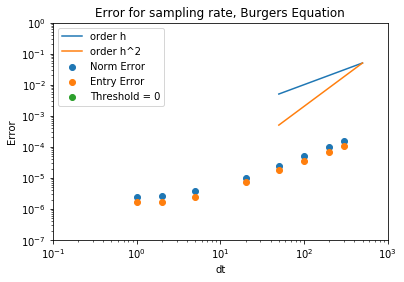

In [11]:
from IPython.display import Image
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\Burger_Error_lele_no_threshold.png")

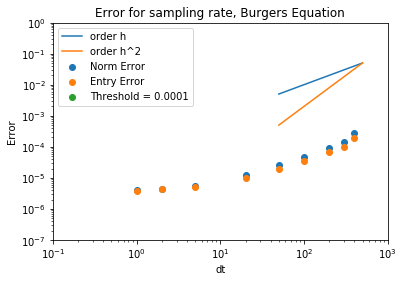

In [12]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\Burger_Error_lele_with_threshold.png")

Comparing both of these images, we can see that the thresholding does not drasitcally impact the convergence of the final solution. We might expect the other sparse regression tools to achieve better results. However, visually, it should be noted that using the thresholding makes it significanly easier when reconstructing the PDE using simulations. 

### Simulation Resolution (dt)

We now consider the simulations resolution for the Burgers Equation. To do this, we consider varying time steps in our initial simulation. We start with $.1$ and continue to $.0001$ before computer memory restricts further analysis. All other parameters have stayed the same and we sample every $100^{th}$ point. To accomodate the larger dt values (and to prevent overflow errors), we rescale our system as follows: 

In [13]:
for step in [1,2,3,4]:
    ### Burgers
    NPoints = 2**11      # Spacial Resolution
    t_stop = 150        # Stoping Time
    dt = 10**(-step)           # Time step size
    sampling_rate = 100   # How often do you save?
    Lx = 1               # Space Size

    # Input Coefficients [1, u, u_x, u_xx, u^2, u*u_x, u*u_xx, u_x^2, u_x*u_xx, u_xx^2]
    c = [0,0,.001,.0000001,0,-.001, 0 ,0,0,0]

We have rescaled our system in time to allow for maintain reasonable $dt$ values. Without this rescaling, we would be considering $dt = 10^{-7}$ at its smallest. While this is pheasable, for convience, we have simply rescaled time and thereby, the coefficients of our equation. Other than this, our simulation is exactly the same as above.

We run these simulations along with model-discovery resgression with and without thresholding. The graphs are displayed below. It should be noted that when considering thresholding, we must accomdate the smallest coeffifcient or expect our error to level-off at $10^{-8}$. Because we have not seen this level of accuracy from general simulations, we use a larger threshold in the regression. 

These simulations are greatly restricted by memory power and computation time. To run high-resolution simulations takes significant amounts of time. These few plots are used to illustrate that, while the accuracy of the above simulations does not go to machine epsilon, better results can be achieved by increasing the resolution of the original data simulation. 

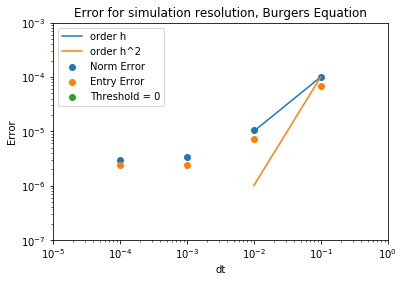

In [14]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\Burgers_Error_dt_no_threshold.png")

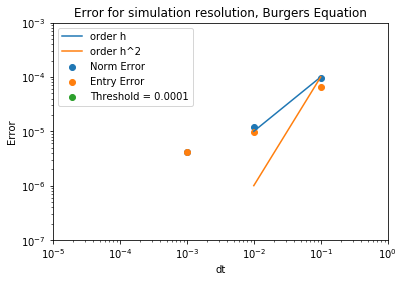

In [15]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\Burgers_Error_dt_with_threshold.png")

## Exploring Different Equations

We have also taken these results and explored other nonlinear pdes. These include the reaction diffusion equation ($u_t = \alpha u_xx + R(u)$) and Complex Ginsburg-Landau (CGL) ($u_t = \mu u + (1+\alpha i) u_{xx} + (1+\beta i)|u|^2u$). We will first discuss the results for the reaction diffusion equation.

### Reaction Diffusion

For our expiriment, we consider the reaction diffusion equation with $R(u) = \beta u(1-u)$. We start with a very generic setup for this equation, with reasonable coefficients and an initial condition of $$u(0,x) = \cos\left(\frac{2\pi x}{L}\right)+\cos\left(\frac{10\pi x}{L}\right).$$

In [16]:
### Reaction Diffusion
NPoints = 2**11      # Spacial Resolution
t_stop = .4        # Stoping Time
dt = .0001           # Time step size
sampling_rate = 10  # How often do you save?
Lx = 1               # Space Size

# Input Coefficients [1, u, u_x, u_xx, u^2, u*u_x, u*u_xx, u_x^2, u_x*u_xx, u_xx^2]
c = [0,-2,0,.001,2,0,0,0,0,0]

We then run the split-step simulation and input the data into SINDy to see if we can discover the same equation. As expected, the results are similar to those from Burger's Equation. 

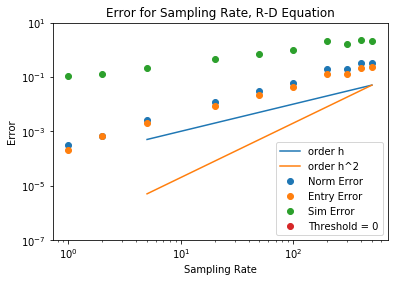

In [17]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\R_D_Error_no_threshold.png")

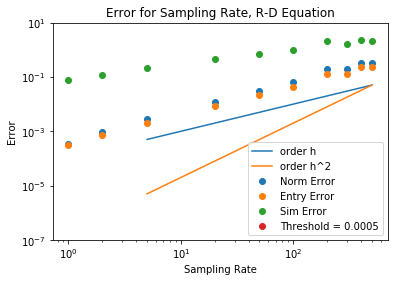

In [18]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\R_D_Error_with_threshold.png")

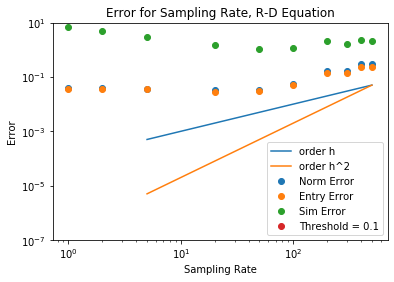

In [19]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\R_D_Error_with_threshold_high.png")

Here, we can see that when using a threshold, the noise causes our error to level off around $10^{-3}$. However, when using the thresholding, we achieve more consistent error results with a convergence rate of $h^2$. This result has not been proven theoretically; however we can visually see this behavior. 

As above, we can also consider the simluation resolution for the Reaction Diffusion equation. These results match those of Burgers equation. We notice no significant difference between the thresholding vs. non-thresholding but, as the simulation's accuracy continues, so does our discovered system. It should be noted that these simulations are computationally burdensome and so higher-resolution simulations take signifcant amounts of time.

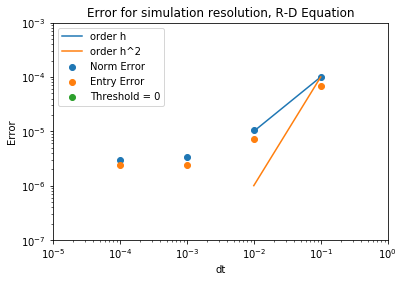

In [20]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\R_D_Error_dt_no_threshold.png")

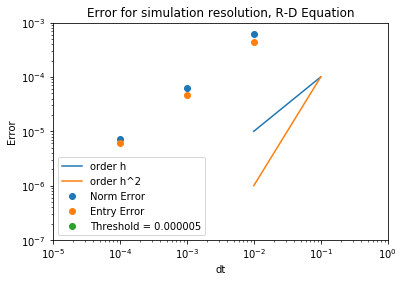

In [21]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\R_D_Error_dt_with_threshold.png")

### CGL (more to come)

In this section we explore nonlinear schrodingers (Complex Ginsburg-Landau) with simulations preformed using the split-step method above. However, when incorperating SINDy as our discovery method, we use cubic terms. This greatly increases the number of possible discovered systems. However, we notice, from the results below, that if we have good sampling of the simulation (or expieriment), that reliable results can be achieved. We will consider the equation 
$$u_t = \mu u + (1+\alpha i) u_{xx} + (1+\beta i)|u|^2u$$ 
with $\mu = 1.1$, $\alpha = 3$ and $\beta = -1.2$ initially. We also consider a spatial domain large enough to allow for 10-15 active modes in the simulation. Other regimes, along with limited data will be considered later. 

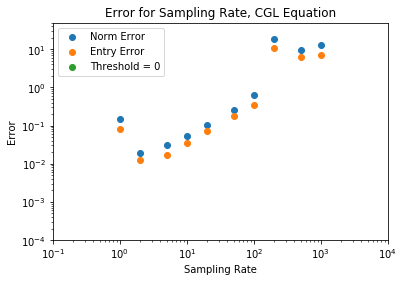

In [22]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\CGL_Error_no_threshold.png")

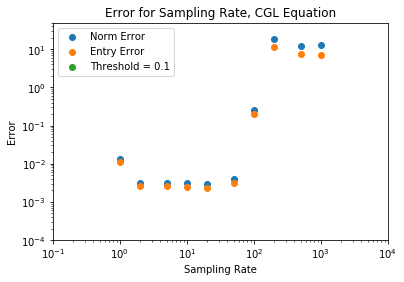

In [23]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\CGL_Error_with_threshold.png")

Again, we notice that we achieve order h convergence. In the case of the CGL we observe the behavior that appeared when studying ODEs and SINDy. That is, when implementing thresholds, the convergence rate is not necessarily imporved, given a certain resolution of the data, the threshold immediately discovers the system. 

Why this has not occured in the previous examples requires more investigation. Potential answers could lie in the idea PDE simulation itself, it might also be an effect of the initial error size. With Burger's and the Reaction Diffusion equations, our worst error was at a magnitude of $10^{-1}$. However, in this case, we are seeing error on the order of 10. This error size was also realized in the ODEs. 

This would imply that when using SINDy and appropriate thresholding, when you're way off, there is little hope. However, this implies that if adjusting the sampling rate of the data does not have a large impact on the results, then SINDy has most likely found the correct terms in the PDE. 

More simulation-based research needs to be done to look at the validity of resimulating the data, as in the reaction diffusion equation. The challenge lies in the potential turblent behavior that CGL equation exhibits. Does SINDy reproduce similar turbulent behavior or do we fall into a more chaotic regime where other methods for verifying the results would be required. 